# Harry Potter and Word2Vec

Word2vec is a method for embedding words into a small latent space which captures semantic meaning. The idea is to use a two layer (one hidden layer) fully connected neural network. The first layer of nodes (representing a one hot encoding of the index of some word $w$) connects to a small hidden layer which then connects to an output layer (representing a one hot encoding of the index of a word that appears near word $w$). Through training, we get the small hidden layer to hold the connection between words and their frequent neighbors.


In this demo, we'll implement word2vec using all seven Harry Potter books as our corpus.



## Libraries

As always, we rely on a lot of libraries.

In [1]:
import pandas as pd
import re
import torch
import torch.nn as nn
import numpy as np
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import urllib.request
import numpy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

## Loading Text

We load the text of Harry Potter from a website and preprocess it. In particular, we only want the chapters of the book and we make all words lowercase. Finally, we remove annoying characters like new lines.

In [2]:
url1 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%201%20-%20The%20Philosopher's%20Stone.txt"
url2 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%202%20-%20The%20Chamber%20of%20Secrets.txt"
url3 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%203%20-%20The%20Prisoner%20of%20Azkaban.txt"
url4 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%204%20-%20The%20Goblet%20of%20Fire.txt"
url5 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%205%20-%20The%20Order%20of%20the%20Phoenix.txt"
url6 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%206%20-%20The%20Half%20Blood%20Prince.txt"
url7 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%207%20-%20The%20Deathly%20Hallows.txt"

def read_file(url, start_phrase, end_phrase, remove):
  with urllib.request.urlopen(url) as webpage:
    text = webpage.read().decode("utf8")
    start = text.index(start_phrase)
    text = text[start:]
    end = text.index(end_phrase)
    text = text[:end]
  return text.lower().replace('\n', '').replace('¬','').replace(',','').replace('.','').replace(remove, '')

text1 = read_file(url1, 'THE BOY WHO LIVED', 'Page | 348', 'Harry Potter and the Philosophers Stone - J.K. Rowling')
text2 = read_file(url2, 'THE WORST BIRTHDAY', 'Page | 380', 'Harry Potter and the Chamber of Secrets - J.K. Rowling')
text3 = read_file(url3, 'OWL POST', 'Page | 487', 'Harry Potter and the Prisoner of Azkaban - J.K. Rowling')
text4 = read_file(url4, 'THE RIDDLE HOUSE', 'Page | 811', 'Harry Potter and the Goblet of Fire - J.K. Rowling')
text5 = read_file(url5, 'DUDLEY DEMENTED', 'Page | 1108', 'Harry Potter and the Order of the Phoenix - J.K. Rowling')
text6 = read_file(url6, 'THE OTHER MINISTER', 'Page | 730', 'Harry Potter and the Half Blood Prince - J.K. Rowling')
text7 = read_file(url7, 'THE DARK LORD ASCENDING', 'Page | 856', 'Harry Potter and the Deathly Hallows - J.K. Rowling')

text = text1 + text2 + text3 + text4 + text5 + text6 + text7

## Tokenizing

Now we tokenize the text. That is, we turn the string into a list of words.

In [3]:
def get_frequent(tokens, threshold=50):
  frequency = {token : 0 for token in set(tokens)}
  for token in tokens:
    frequency[token] += 1
  
  frequent_tokens = []
  for token in tokens:
    if frequency[token] >= threshold:
      frequent_tokens += [token]
  
  return frequent_tokens, len(set(tokens))

In [4]:
letters = 'abcdefghijklmnopqrstuvwxyz'
def process_word(word):
  return ''.join([letter for letter in word if letter in letters])
tokens = [process_word(word) for word in text.split(' ')]

tokens, num_tokens = get_frequent(tokens)
print(tokens[:100])

['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'in', 'anything', 'strange', 'or', 'because', 'they', 'just', 'didnt', 'hold', 'with', 'such', 'mr', 'dursley', 'was', 'the', 'of', 'a', 'called', 'which', 'made', 'he', 'was', 'a', 'big', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mrs', 'dursley', 'was', 'thin', 'and', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'over', 'garden']


In [5]:
print(f'There are {len(tokens)} total tokens and {num_tokens} unique tokens.')

There are 1036183 total tokens and 23182 unique tokens.


Now we map from each word (token) to a unique index and back. We will use this for the one hot encoding of the word.

In [6]:
def mapping(tokens):
  word_to_id = {}
  id_to_word = {}

  for i, token in enumerate(set(tokens)):
    word_to_id[token] = i
    id_to_word[i] = token
  
  return word_to_id, id_to_word

WORD_TO_ID, ID_TO_WORD = mapping(tokens)
num_tokens = len(set(tokens))

The next step is to get the dataset we will use. We do this by iterating through the tokens with a sliding window. For each word $w$, we look at its neighbors $u$ and add a data point $(w,u)$ where we need to predict $u$ on input $w$. For now, we store the data as indices to avoid carrying around a bunch of zeros in the one hot encoding.

In [41]:
def convert(x):
  return torch.tensor(np.asarray(x)).long()
  
def process(tokens, window=2, threshold=100):
  frequency = {WORD_TO_ID[token]: 0 for token in set(tokens)}
  X, y = [], []
  for i in range(len(tokens)-1):
    index_i = WORD_TO_ID[tokens[i]]
    if frequency[index_i] < threshold:
      for j in list(range(max(0,i-window), min(len(tokens), i+window+1))):
        index_j = WORD_TO_ID[tokens[j]]
        #if frequency[index_j] < threshold:
        X += [index_i]
        y += [index_j]
        frequency[index_i] += 1
        frequency[index_j] += 1
  return X, y

# Initialization

Now we define the custom class we need so we can wrap the nice DataLoader function around our dataset.

In [42]:
class DataSet(Dataset):
  def __init__(self, tokens):
    X,y = process(tokens)
    self.X = X
    self.y = y
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx] 

dataloader = DataLoader(DataSet(tokens), batch_size = 128, shuffle=True)

In [43]:
class Word2Vec(nn.Module):
  def __init__(self, num_tokens, embed_dim):
    super(Word2Vec, self).__init__()
    self.embedding = nn.Embedding(num_tokens, embed_dim)
  
  def forward(self, x):
    return self.embedding(x)


In [44]:
def contrastive_loss(X_embedded, y_embedded):
  batch_size = len(X_embedded)
  gram = X_embedded @ y_embedded.T
  difference = gram - torch.eye(batch_size).to(DEVICE)
  return torch.sqrt(torch.square(difference).sum()/batch_size**2)

Finally, we're ready to initialize the architecture, loss, and optimizer. Notice the simplicity of the model!

In [45]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64

model = Word2Vec(num_tokens, embed_dim).to(DEVICE)

losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

Now let's train.

In [46]:
num_epochs = 20

for epoch in range(1, num_epochs+1):
  total_loss = 0
  for (X,y) in dataloader:
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    optimizer.zero_grad()
    X_embedded = model(X)    
    y_embedded = model(y)    
    loss = contrastive_loss(X_embedded, y_embedded)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  losses += [total_loss/len(dataloader)]
  print(f'Epoch: {epoch} \t Loss: {loss}')


Epoch: 1 	 Loss: 5.720444679260254
Epoch: 2 	 Loss: 4.175797462463379
Epoch: 3 	 Loss: 2.2377748489379883
Epoch: 4 	 Loss: 1.725404143333435
Epoch: 5 	 Loss: 0.7257508039474487
Epoch: 6 	 Loss: 0.7060225009918213
Epoch: 7 	 Loss: 0.3669140040874481
Epoch: 8 	 Loss: 0.2837032377719879
Epoch: 9 	 Loss: 0.20808711647987366
Epoch: 10 	 Loss: 0.19845540821552277
Epoch: 11 	 Loss: 0.2003568857908249
Epoch: 12 	 Loss: 0.20517590641975403
Epoch: 13 	 Loss: 0.20199234783649445
Epoch: 14 	 Loss: 0.19729004800319672
Epoch: 15 	 Loss: 0.19830188155174255
Epoch: 16 	 Loss: 0.1898644119501114
Epoch: 17 	 Loss: 0.19841112196445465
Epoch: 18 	 Loss: 0.20193296670913696
Epoch: 19 	 Loss: 0.1928645223379135
Epoch: 20 	 Loss: 0.191421240568161


## Exploring the Embeddings

What is the next word predicted?

In [62]:
target = torch.tensor([WORD_TO_ID['quidditch']]).to(DEVICE)
candidates = torch.tensor(list(ID_TO_WORD.keys())).to(DEVICE)
candidates_embedded = model(candidates)
target_embedded = model(target)

similarities = candidates_embedded @ target_embedded.T
_, indices = torch.topk(similarities.squeeze(), 10)

for index in indices:
  print(ID_TO_WORD[index.item()])

pitch
quidditch
practice
game
final
cup
playing
play
ended
match


To investigate the model, let's visualize the embeddings of the words.

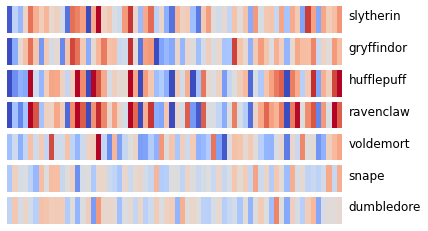

In [64]:
def embed(word):
  return model(torch.tensor(WORD_TO_ID[word]).to(DEVICE)).detach().cpu().numpy()

words = ['slytherin', 'gryffindor', 'hufflepuff', 'ravenclaw',
         'voldemort', 'snape', 'dumbledore']
embeddings = [embed(word) for word in words] 
num_embed = len(embeddings)
cmap = matplotlib.cm.coolwarm
fig, axes = plt.subplots(num_embed, 1)
norm = matplotlib.colors.Normalize(vmin=embeddings[0].min(), vmax=embeddings[0].max())
for idx in range(num_embed):
  ax = axes[idx]
  embedding = embeddings[idx]
  for i in range(embed_dim):
    ax.add_patch(Rectangle((i/embed_dim, 0),.05,1, color=cmap(norm(embedding[i]))))
  ax.text(1.02, .5, words[idx], fontsize=12)
  ax.axis('off')
plt.show()